# **Импорт библиотек**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install torch
!pip install transformers bitsandbytes>=0.39.0 accelerate sentencepiece onnx -q
import torch
from transformers import AutoTokenizer, AutoModel

# **Обработка датасета с новостями эмитентов с помощью эмбеддингов**


In [ ]:
all_news = pd.read_csv('all_news.csv')
all_news.head()

Unnamed: 0        Date  Company  \
0        2829  2024-12-23   magnit   
1        2828  2024-12-20  positiv   
2        2827  2024-12-20   lukoil   
3        2826  2024-12-19  positiv   
4        2825  2024-12-19   magnit   

                                              Header  \
0  Приобретение подконтрольной эмитенту организац...   
1           Совершение эмитентом существенной сделки   
2  Проведение заседания совета директоров (наблюд...   
3        Решения единственного акционера (участника)   
4  Выплаченные доходы или иные выплаты, причитающ...   

                                           Full_news  
0  Сообщение о существенном факте\nо приобретении...  
1  Совершение эмитентом существенной сделки\n\n1....  
2  СООБЩЕНИЕ О СУЩЕСТВЕННОМ ФАКТЕ\n О ПРОВЕДЕНИИ ...  
3  Решения единственного акционера (участника)\n\...  
4  Сообщение\nо выплаченных доходах по ценным бум...

**Применим модель для перевода новостей из естественного языка в эмбеддинги**


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

def get_bert_embedding(text):

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Перемещаем результат обратно на CPU

all_news["embedding"] = all_news["Full_news"].apply(get_bert_embedding)

all_news.head()

Unnamed: 0        Date  Company  \
0        2829  2024-12-23   magnit   
1        2828  2024-12-20  positiv   
2        2827  2024-12-20   lukoil   
3        2826  2024-12-19  positiv   
4        2825  2024-12-19   magnit   

                                              Header  \
0  Приобретение подконтрольной эмитенту организац...   
1           Совершение эмитентом существенной сделки   
2  Проведение заседания совета директоров (наблюд...   
3        Решения единственного акционера (участника)   
4  Выплаченные доходы или иные выплаты, причитающ...   

                                           Full_news  \
0  Сообщение о существенном факте\nо приобретении...   
1  Совершение эмитентом существенной сделки\n\n1....   
2  СООБЩЕНИЕ О СУЩЕСТВЕННОМ ФАКТЕ\n О ПРОВЕДЕНИИ ...   
3  Решения единственного акционера (участника)\n\...   
4  Сообщение\nо выплаченных доходах по ценным бум...   

                                           embedding  
0  [0.5406755, -0.7683334, -0.88949114, -0.608709...  
1  [-0.11709095, -0.2378149, -0.76591974, -0.7301...  
2  [0.6958057, 0.1007129, 0.010414924, -0.0278663...  
3  [-0.0025722983, -0.48915774, -0.5681367, -0.30...  
4  [0.44229534, -0.29075927, -0.671164, -0.498257...

## **Объединим по дате выхода новости датасет с эмбеддингами и данные по котировкам акций**


In [ ]:
all_stocks = pd.read_csv('all_stocks.csv')
all_merged = pd.merge(all_news, all_stocks, on = ['Date', 'Company'], how='outer')
all_merged['Date'] = pd.to_datetime(all_merged['Date'])
all_merged = all_merged.sort_values(by = 'Date', ascending = False)
all_merged.index = range(len(all_merged))
all_merged['Day'] = all_merged['Date'].dt.day_name()
all_merged = all_merged[['Date', 'Day', 'Company', 'Header', 'embedding', 'Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %']]
all_merged['Date'] = (pd.to_datetime(all_merged['Date']))
all_merged.to_csv('all_merged.csv')
all_merged

Date        Day  Company Header embedding     Цена    Откр.  \
0    2024-12-24    Tuesday     sber    NaN       NaN   264.34   264.94   
1    2024-12-24    Tuesday  positiv    NaN       NaN  1901.00  2019.00   
2    2024-12-24    Tuesday     nlmk    NaN       NaN   133.66   135.00   
3    2024-12-24    Tuesday   magnit    NaN       NaN  4945.50  4984.50   
4    2024-12-24    Tuesday   lukoil    NaN       NaN  6833.00  6919.00   
...         ...        ...      ...    ...       ...      ...      ...   
6835 2018-01-04   Thursday   magnit    NaN       NaN  6629.00  6490.00   
6836 2018-01-04   Thursday   lukoil    NaN       NaN  3501.00  3428.00   
6837 2018-01-03  Wednesday   magnit    NaN       NaN  6485.00  6327.00   
6838 2018-01-03  Wednesday   lukoil    NaN       NaN  3421.50  3340.00   
6839 2017-12-29     Friday   magnit    NaN       NaN  6340.00  6252.00   

        Макс.     Мин.    Объём  Изм. %  
0      266.62   261.03   83,81M   -0.21  
1     2011.40  1891.00    1,08M   -5.73  
2      136.10   131.46    9,97M   -0.33  
3     4984.50  4872.50  504,40K   -0.77  
4     6959.50  6825.00  724,13K   -1.24  
...       ...      ...      ...     ...  
6835  6640.00  6480.00  171,24K    2.22  
6836  3501.00  3392.50  702,06K    2.32  
6837  6485.00  6322.00  140,86K    2.29  
6838  3421.50  3340.00  395,93K    2.61  
6839  6377.00  6251.00  155,92K    1.12  

[6840 rows x 11 columns]

**Добавим колонки с логарифмическими доходностями цен акций на лагах в 1, 2 и 3 дня**

In [ ]:
final_df = pd.DataFrame()
for company in all_merged['Company'].unique():
    company_df = all_merged[all_merged['Company'] == f'{company}'].copy()
    company_df['Лаг 3 дня %'] = (np.log(company_df['Цена'].shift(3) / company_df['Цена'])) * 100
    company_df['Лаг 2 дня %'] = (np.log(company_df['Цена'].shift(2) / company_df['Цена'])) * 100
    company_df['Лаг 1 день %'] = np.log(company_df['Цена'].shift(1) / company_df['Цена']) * 100
    final_df = pd.concat([final_df, company_df], ignore_index=True)
final_df.to_csv('final_df.csv')
final_df.dropna(inplace = True)
final_df

Date        Day Company  \
29   2024-11-13  Wednesday    sber   
30   2024-11-12    Tuesday    sber   
31   2024-11-11     Monday    sber   
32   2024-11-08     Friday    sber   
33   2024-11-07   Thursday    sber   
...         ...        ...     ...   
6828 2018-01-19     Friday  lukoil   
6830 2018-01-17  Wednesday  lukoil   
6832 2018-01-15     Monday  lukoil   
6833 2018-01-12     Friday  lukoil   
6835 2018-01-10  Wednesday  lukoil   

                                                 Header  \
29    События (действия), оказывающие, по мнению эми...   
30    События (действия), оказывающие, по мнению эми...   
31    Завершение размещения ценных бумаг Присвоение ...   
32    Решения совета директоров (наблюдательного сов...   
33    Включение эмиссионных ценных бумаг эмитента в ...   
...                                                 ...   
6828  Сведения, направленные за пределы РФ для их ра...   
6830  Сведения, направленные за пределы РФ для их ра...   
6832  Сведения, направленные за пределы РФ для их ра...   
6833  Сведения, направленные за пределы РФ для их ра...   
6835  Раскрытие в сети Интернет списка аффилированны...   

                                              embedding     Цена    Откр.  \
29    [0.06433032, -0.4989491, -0.6328373, -0.573905...   254.70   255.29   
30    [0.036952827, -0.59659576, -0.7055809, -0.4622...   255.77   259.99   
31    [0.47232062, -0.30909607, -0.33422765, -0.3731...   260.73   257.99   
32    [-0.070676096, 0.084975265, -0.38239866, -0.09...   255.98   251.50   
33    [0.70279765, -0.4212318, -0.59127706, -0.44067...   250.93   243.26   
...                                                 ...      ...      ...   
6828  [0.45426443, -0.31443235, -0.47955483, -0.5364...  3825.50  3850.00   
6830  [0.48195738, -0.19865583, -0.524104, -0.450353...  3851.50  3846.50   
6832  [0.45426443, -0.31443235, -0.47955483, -0.5364...  3876.50  3932.00   
6833  [0.14611025, -0.16416335, 0.10192801, -0.43700...  3908.00  3677.00   
6835  [0.37957716, 0.025489274, -0.042771846, -0.654...  3641.00  3640.00   

        Макс.     Мин.    Объём  Изм. %  Лаг 3 дня %  Лаг 2 дня %  \
29     258.96   254.05   44,54M   -0.42    -2.375862    -0.499873   
30     260.70   255.27   40,93M   -1.90    -0.919095    -2.473953   
31     261.30   256.49   67,85M    1.86    -4.394632    -2.339901   
32     255.99   250.50   58,09M    2.01    -0.501293    -0.082071   
33     251.00   242.16   44,43M    3.01     1.910459     3.831137   
...       ...      ...      ...     ...          ...          ...   
6828  3885.50  3801.00  662,93K   -0.77     0.638397     0.417374   
6830  3868.50  3811.00  808,22K   -0.27     0.479182    -0.677351   
6832  3985.00  3876.50  928,15K   -0.81    -0.556168    -0.647000   
6833  3942.00  3650.00    2,68M    5.98    -1.456305    -1.184055   
6835  3649.00  3594.50    1,03M    0.34     6.267432     7.076736   

      Лаг 1 день %  
29       -2.054731  
30       -0.419222  
31       -1.920679  
32        1.838607  
33        1.992530  
...            ...  
6828      1.156533  
6830      0.090832  
6832     -0.374750  
6833     -0.809305  
6835      1.269035  

[2746 rows x 14 columns]

## **Удалим все наблюдения где абсолютное изменение логарифмической доходности на лаге в 1 день было больше 10%. Это скорее всего событие, вызваное не новостями эмитентов, а макроэкономическими шоками. Посмотрим, в какие дни они произошли**

**На графиках логарифмических доходностей можно заметить выбросы, это, вероятно дни, на которых отразились макроэкономические шоки. Посмотрим, что это за дни**





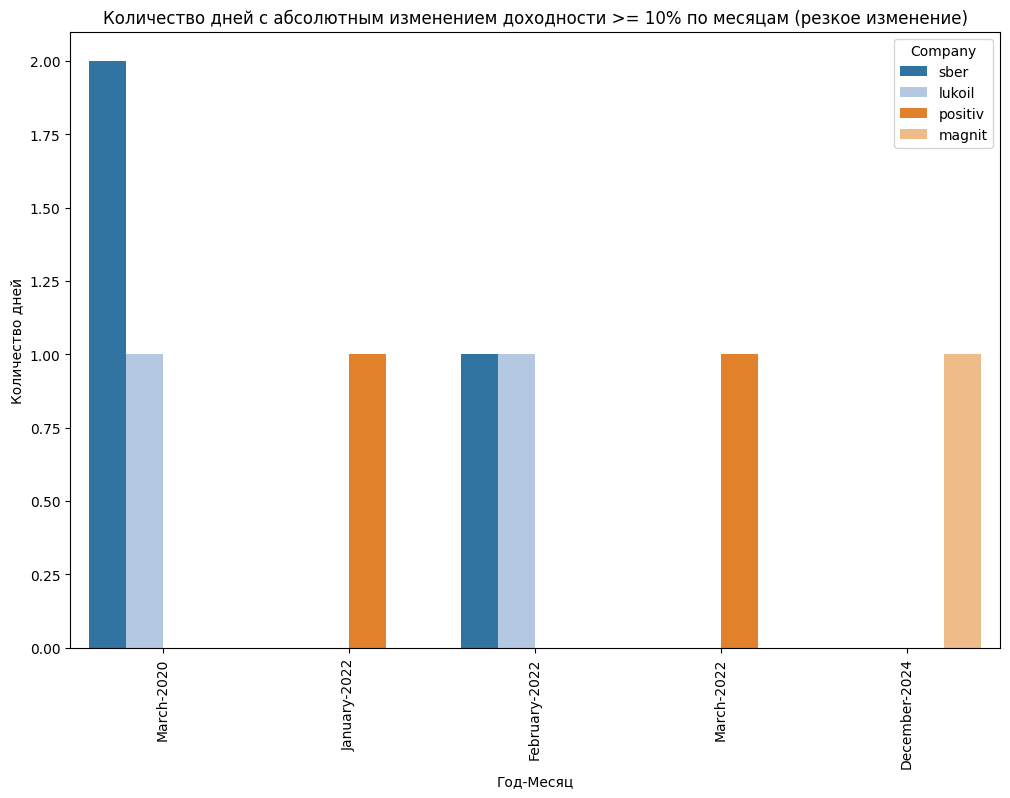

In [ ]:
over_10 = final_df[abs(final_df['Лаг 1 день %']) >= 10].copy()
over_10['year_month_str'] = over_10['Date'].dt.strftime('%B-%Y')
over_10 = over_10.sort_values(by = 'Date')


plt.figure(figsize = (12,8));
sns.countplot(data = over_10,  x = 'year_month_str', hue = 'Company', palette = 'tab20');
plt.title('Количество дней с абсолютным изменением доходности >= 10% по месяцам (резкое изменение)')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество дней')
plt.xticks(rotation = 90);

**Действительно, сильные выбросы в логарифмических доходностях вызваны не новостями эмитентов, а глобальными событиями, такими как пандемия коронавируса в марте 2020, наложение санкций в начале 2022 и установление высокой ключевой ставки в рамках проведения жесткой денежно-кредитной политики Центробанка в декабре 2024 года**

In [ ]:
final_df = final_df[abs(final_df['Лаг 1 день %']) < 10]

## **Перевод эмбеддингов в массив numpy**

In [ ]:
embeddings = np.array(final_df['embedding'].tolist())  # Преобразуем список эмбеддингов в массив numpy
df_embeddings = pd.DataFrame(embeddings)
df_embeddings.columns = [f'emb_{i}' for i in range(df_embeddings.shape[1])]
df_embeddings

emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0     0.064330 -0.498949 -0.632837 -0.573905 -0.269392  0.557923 -0.226986   
1     0.036953 -0.596596 -0.705581 -0.462228 -0.100700  0.279105 -0.204765   
2     0.472321 -0.309096 -0.334228 -0.373150  0.087259  0.082579  0.198904   
3    -0.070676  0.084975 -0.382399 -0.098793 -0.415218  0.639691  0.069984   
4     0.702798 -0.421232 -0.591277 -0.440671  0.383605 -0.045919  0.106735   
...        ...       ...       ...       ...       ...       ...       ...   
2733  0.454264 -0.314432 -0.479555 -0.536440  0.298219  0.114676  0.250044   
2734  0.481957 -0.198656 -0.524104 -0.450354  0.195236  0.150431  0.177595   
2735  0.454264 -0.314432 -0.479555 -0.536440  0.298219  0.114676  0.250044   
2736  0.146110 -0.164163  0.101928 -0.437001 -0.149088  0.134057  0.258452   
2737  0.379577  0.025489 -0.042772 -0.654108  0.174517  0.203847  0.394828   

         emb_7     emb_8     emb_9  ...   emb_302   emb_303   emb_304  \
0    -0.675808  0.275286  1.215616  ...  0.528213  0.523044 -0.186555   
1    -0.813799  0.448292  1.201431  ...  0.472448  0.395335 -0.152724   
2    -0.396241  0.341360  0.931698  ...  0.612485  0.548495 -0.509684   
3    -1.012657  0.481872  1.064607  ...  0.572723  0.583147 -0.148286   
4    -0.543155  0.014663  0.905846  ...  0.180293  0.433918 -0.726971   
...        ...       ...       ...  ...       ...       ...       ...   
2733 -0.574566  0.501177  1.193376  ...  0.669118  0.057145 -0.353897   
2734 -0.611588  0.512471  1.234450  ...  0.680182  0.062912 -0.302808   
2735 -0.574566  0.501177  1.193376  ...  0.669118  0.057145 -0.353897   
2736 -0.692754  0.621542  0.573491  ...  0.441091 -0.013703 -0.040152   
2737 -0.613186 -0.010145  0.816737  ...  0.341105  0.404126 -0.604106   

       emb_305   emb_306   emb_307   emb_308   emb_309   emb_310   emb_311  
0     0.443646 -0.635938  0.353924  0.389554  0.387762  0.543400 -0.789982  
1     0.485964 -0.604598  0.271844  0.357001  0.211569  0.477666 -0.608887  
2     0.609152 -0.594624  0.010196  0.166807  0.041005  0.739752 -0.612903  
3     0.304619 -0.849141  0.122106 -0.243367  0.121756  0.596090 -0.487069  
4     0.593498 -0.498514  0.282910  0.291301  0.012194  0.612657 -0.631145  
...        ...       ...       ...       ...       ...       ...       ...  
2733  0.307159 -0.979092  0.130008  0.465279  0.478538  0.528811 -0.569970  
2734  0.298704 -1.048434  0.109350  0.434620  0.428118  0.495528 -0.573322  
2735  0.307159 -0.979092  0.130008  0.465279  0.478538  0.528811 -0.569970  
2736  0.372285 -0.108308  0.337853  0.124934  0.392258  0.296955 -0.514170  
2737  0.551616 -0.581542  0.044006  0.226238  0.677786  0.680860 -0.616028  

[2738 rows x 312 columns]

**Добавление категориальных признаков - названий компаний**

In [ ]:
categor_df = pd.get_dummies(data = final_df, columns = ['Company'], drop_first = False)
categorial = categor_df[['Company_lukoil', 'Company_magnit',	'Company_nlmk',	'Company_positiv',	'Company_sber']].reset_index().drop('index', axis = 1)
categorial = categorial[['Company_lukoil', 'Company_magnit',	'Company_nlmk',	'Company_positiv',	'Company_sber']].astype(int)
categorial.head()

Company_lukoil  Company_magnit  Company_nlmk  Company_positiv  Company_sber
0               0               0             0                0             1
1               0               0             0                0             1
2               0               0             0                0             1
3               0               0             0                0             1
4               0               0             0                0             1

**Получим массив регрессоров, состоящий из эмбеддингов и названий компаний**

In [ ]:
regressor = df_embeddings.copy()
regressor[['Company_lukoil', 'Company_magnit',	'Company_nlmk',	'Company_positiv',	'Company_sber']] = categorial
regressor

emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0     0.064330 -0.498949 -0.632837 -0.573905 -0.269392  0.557923 -0.226986   
1     0.036953 -0.596596 -0.705581 -0.462228 -0.100700  0.279105 -0.204765   
2     0.472321 -0.309096 -0.334228 -0.373150  0.087259  0.082579  0.198904   
3    -0.070676  0.084975 -0.382399 -0.098793 -0.415218  0.639691  0.069984   
4     0.702798 -0.421232 -0.591277 -0.440671  0.383605 -0.045919  0.106735   
...        ...       ...       ...       ...       ...       ...       ...   
2733  0.454264 -0.314432 -0.479555 -0.536440  0.298219  0.114676  0.250044   
2734  0.481957 -0.198656 -0.524104 -0.450354  0.195236  0.150431  0.177595   
2735  0.454264 -0.314432 -0.479555 -0.536440  0.298219  0.114676  0.250044   
2736  0.146110 -0.164163  0.101928 -0.437001 -0.149088  0.134057  0.258452   
2737  0.379577  0.025489 -0.042772 -0.654108  0.174517  0.203847  0.394828   

         emb_7     emb_8     emb_9  ...   emb_307   emb_308   emb_309  \
0    -0.675808  0.275286  1.215616  ...  0.353924  0.389554  0.387762   
1    -0.813799  0.448292  1.201431  ...  0.271844  0.357001  0.211569   
2    -0.396241  0.341360  0.931698  ...  0.010196  0.166807  0.041005   
3    -1.012657  0.481872  1.064607  ...  0.122106 -0.243367  0.121756   
4    -0.543155  0.014663  0.905846  ...  0.282910  0.291301  0.012194   
...        ...       ...       ...  ...       ...       ...       ...   
2733 -0.574566  0.501177  1.193376  ...  0.130008  0.465279  0.478538   
2734 -0.611588  0.512471  1.234450  ...  0.109350  0.434620  0.428118   
2735 -0.574566  0.501177  1.193376  ...  0.130008  0.465279  0.478538   
2736 -0.692754  0.621542  0.573491  ...  0.337853  0.124934  0.392258   
2737 -0.613186 -0.010145  0.816737  ...  0.044006  0.226238  0.677786   

       emb_310   emb_311  Company_lukoil  Company_magnit  Company_nlmk  \
0     0.543400 -0.789982               0               0             0   
1     0.477666 -0.608887               0               0             0   
2     0.739752 -0.612903               0               0             0   
3     0.596090 -0.487069               0               0             0   
4     0.612657 -0.631145               0               0             0   
...        ...       ...             ...             ...           ...   
2733  0.528811 -0.569970               1               0             0   
2734  0.495528 -0.573322               1               0             0   
2735  0.528811 -0.569970               1               0             0   
2736  0.296955 -0.514170               1               0             0   
2737  0.680860 -0.616028               1               0             0   

      Company_positiv  Company_sber  
0                   0             1  
1                   0             1  
2                   0             1  
3                   0             1  
4                   0             1  
...               ...           ...  
2733                0             0  
2734                0             0  
2735                0             0  
2736                0             0  
2737                0             0  

[2738 rows x 317 columns]

# **Применение моделей машинного обучения для предсказания изменений логарифмических доходностей цен акций на основе новостного сентимента**


**Входные данные:**



**Регрессоры - набор из эмбеддингов и принадлежности к компании для каждого наблюдения**



**Регрессант - изменение логарифмической доходности с лагом 1 день**

**Тестовая выборка - 20% от всего набора новостей**


In [ ]:
from sklearn.model_selection import train_test_split
X = regressor
y = final_df['Лаг 1 день %']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Модель RandomForest с подбором гиперпараметров**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(n_estimators = 300, min_samples_leaf = 1, min_samples_split = 2, max_depth = 10)
forest_model.fit(X_train, y_train)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred_test = forest_model.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred_test)
MSE_test = mean_squared_error(y_test, y_pred_test)
RMSE_test = np.sqrt(MSE_test)
std_test = np.std(y_test)
R2_test = r2_score(y_test, y_pred_test)

y_pred_train = forest_model.predict(X_train)
MAE_train = mean_absolute_error(y_train, y_pred_train)
MSE_train = mean_squared_error(y_train, y_pred_train)
RMSE_train = np.sqrt(MSE_train)
std_train = np.std(y_train)
R2_train = r2_score(y_train, y_pred_train)
print({'MAE_test': MAE_test, 'MSE_test': MSE_test, 'RMSE_test': RMSE_test, 'std_test': std_test, 'R2_test': R2_test})
print({'MAE_train': MAE_train, 'MSE_train': MSE_train, 'RMSE_train': RMSE_train, 'std_train': std_train, 'R2_train': R2_train})

{'MAE_test': 1.2736489916515081, 'MSE_test': 3.317939726830198, 'RMSE_test': np.float64(1.8215212671912997), 'std_test': 1.8025717057550117, 'R2_test': -0.021135542232719073}
{'MAE_train': 1.2043668662247577, 'MSE_train': 2.7144476994680993, 'RMSE_train': np.float64(1.6475581020006849), 'std_train': 1.9202520516205352, 'R2_train': 0.26385222675182207}


## **Модель RandomForest без подбора гиперпараметров**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred_test = forest_model.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred_test)
MSE_test = mean_squared_error(y_test, y_pred_test)
RMSE_test = np.sqrt(MSE_test)
std_test = np.std(y_test)
R2_test = r2_score(y_test, y_pred_test)

y_pred_train = forest_model.predict(X_train)
MAE_train = mean_absolute_error(y_train, y_pred_train)
MSE_train = mean_squared_error(y_train, y_pred_train)
RMSE_train = np.sqrt(MSE_train)
std_train = np.std(y_train)
R2_train = r2_score(y_train, y_pred_train)
print({'MAE_test': MAE_test, 'MSE_test': MSE_test, 'RMSE_test': RMSE_test, 'std_test': std_test, 'R2_test': R2_test})
print({'MAE_train': MAE_train, 'MSE_train': MSE_train, 'RMSE_train': RMSE_train, 'std_train': std_train, 'R2_train': R2_train})

{'MAE_test': 1.3108922941359933, 'MSE_test': 3.49691432988984, 'RMSE_test': np.float64(1.8700038315174223), 'std_test': 1.8025717057550117, 'R2_test': -0.07621711193796221}
{'MAE_train': 0.5558862102701136, 'MSE_train': 0.6457953199052091, 'RMSE_train': np.float64(0.8036139122148205), 'std_train': 1.9202520516205352, 'R2_train': 0.8248627937036805}


## **Применение моделей RandomForest, SupportVectorMachines, GradientBoosting, XGBoost, LightGBM**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


X = regressor
y = final_df['Лаг 1 день %']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(n_estimators=150,
                                         max_depth=10,
                                         random_state=42,
                                         n_jobs=-1),

    "Support Vector": make_pipeline(StandardScaler(with_mean=False),
                                 SVR(kernel='rbf', C=1.0, epsilon=0.1)),

    "Gradient Boosting": GradientBoostingRegressor(n_estimators=150,
                                                 learning_rate=0.1,
                                                 max_depth=5,
                                                 random_state=42),

    "XGBoost": XGBRegressor(n_estimators=150,
                           learning_rate=0.1,
                           max_depth=5,
                           random_state=42,
                           n_jobs=-1),

    "LightGBM": LGBMRegressor(n_estimators=150,
                             learning_rate=0.1,
                             max_depth=5,
                             random_state=42,
                             n_jobs=-1)
}

print("Результаты кросс-валидации (R2 score):")
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train,
                            cv=5, scoring='r2', n_jobs=-1)
    cv_results[name] = scores.mean()
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")


print("\nОценка на тестовом наборе:")
test_results = []
for name, model in models.items():

    model.fit(X_train, y_train)


    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    std_test = np.std(y_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    std_train = np.std(y_train)
    test_results.append({
        'Model': name,
        'mse_test': mse_test,
        'mse_train': mse_train,
        'rmse_test': rmse_test,
        'std_test': std_test,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'r2_train': r2_train,
        'std_train': std_train
    })

print(test_results)

Результаты кросс-валидации (R2 score):
Random Forest: -0.042 ± 0.013
Support Vector: -0.017 ± 0.016
Gradient Boosting: -0.166 ± 0.062
XGBoost: -0.171 ± 0.057
LightGBM: -0.161 ± 0.076

Оценка на тестовом наборе:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79561
[LightGBM] [Info] Number of data points in the train set: 2190, number of used features: 317
[LightGBM] [Info] Start training from score 0.074126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

### **Результаты работы моделей**

In [ ]:
pd.DataFrame(test_results)

Model  mse_test  mse_train  rmse_test  std_test  rmse_train  \
0      Random Forest  3.322526   2.737580   1.822780  1.802572    1.654563   
1     Support Vector  3.288470   3.604854   1.813414  1.802572    1.898645   
2  Gradient Boosting  3.743816   1.006206   1.934894  1.802572    1.003098   
3            XGBoost  3.529359   0.879251   1.878659  1.802572    0.937684   
4           LightGBM  3.705328   1.043389   1.924923  1.802572    1.021464   

    r2_test  r2_train  std_train  
0 -0.022547  0.257579   1.920252  
1 -0.012066  0.022377   1.920252  
2 -0.152204  0.727121   1.920252  
3 -0.086202  0.761551   1.920252  
4 -0.140359  0.717037   1.920252

**Полученные результаты говорят о том, что простое предсказание средним работает лучше, чем применение моделей машинного обучения, об этом говорят:**


**1. Отрицательная метрика R^2-score для тестового набора для каждой модели**


**2. На тестовом наборе для каждой модели стандартное отклонение std_test меньше корня из среднеквадратической ошибки rmse_test**

## **Визуализация результатов на примере предсказания модели RandomForest для каждой компании**

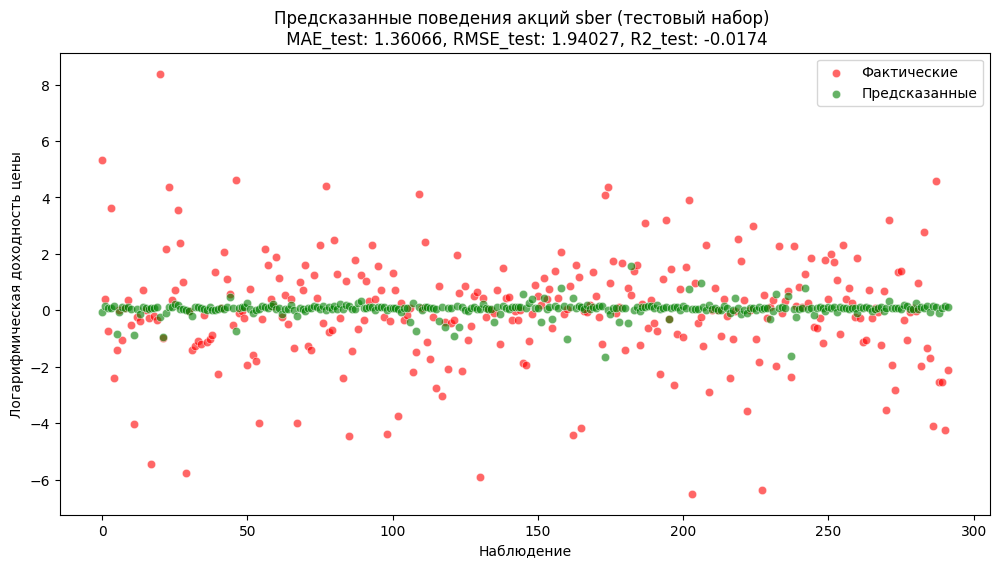

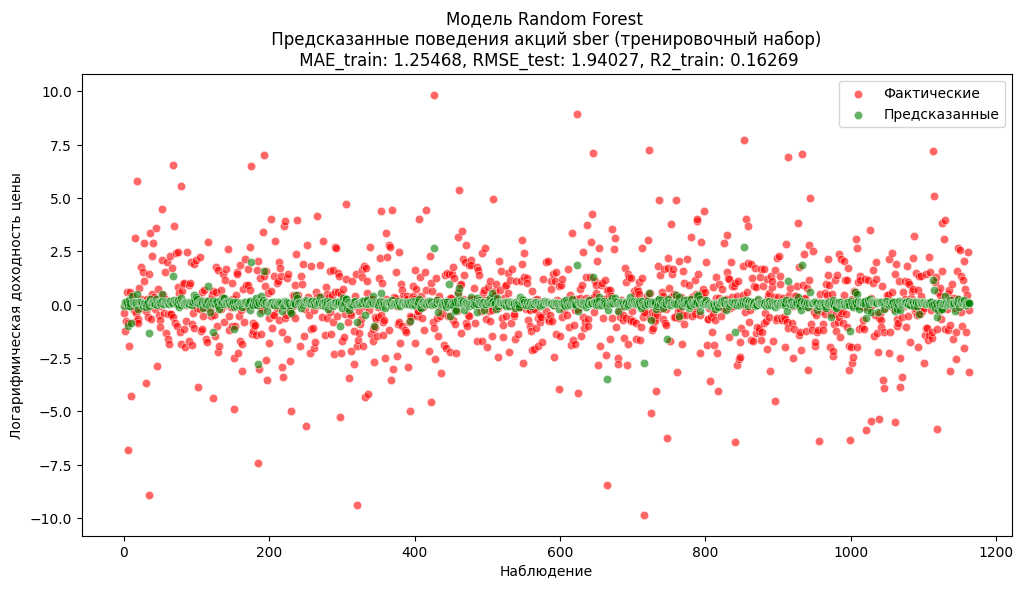

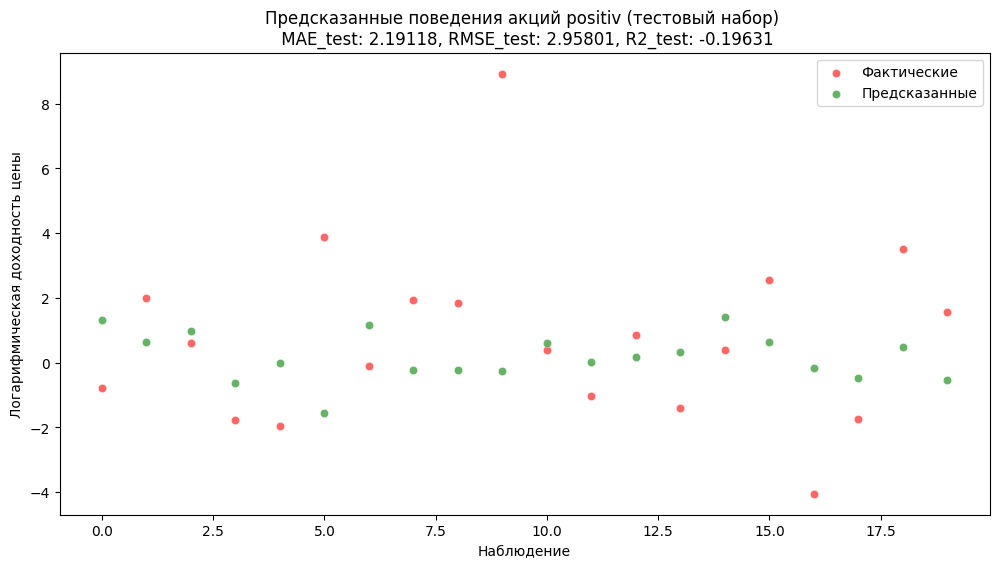

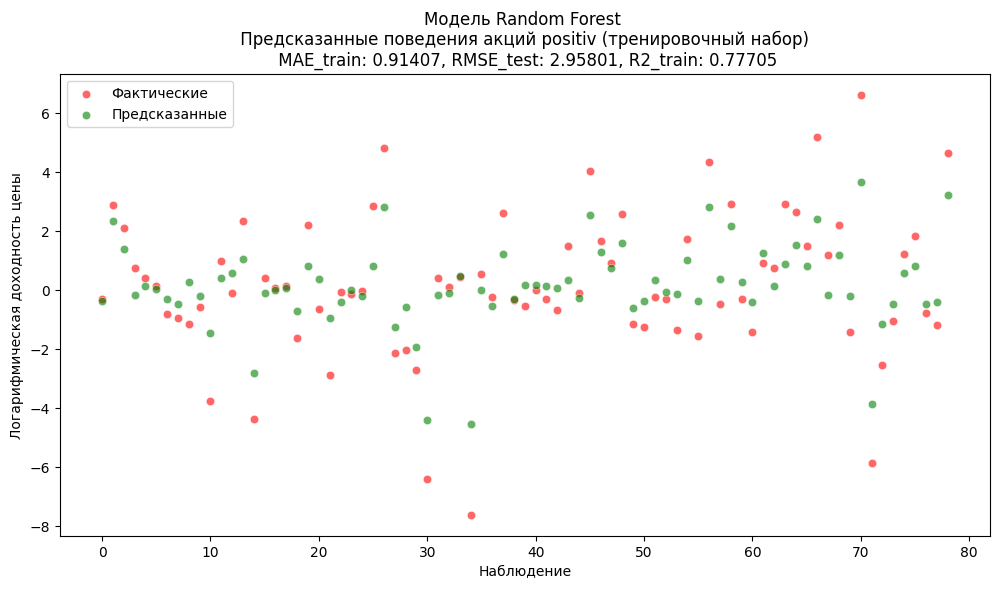

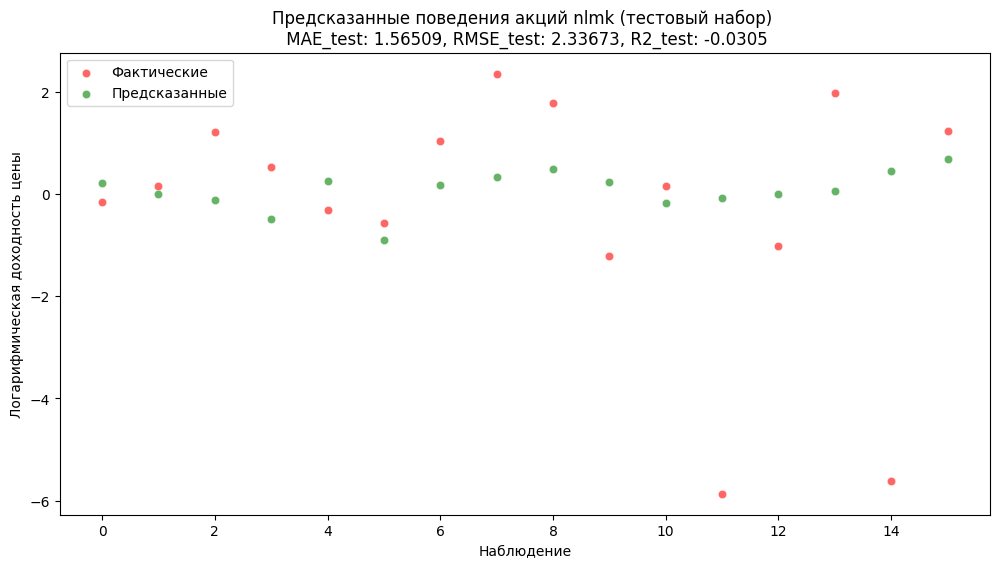

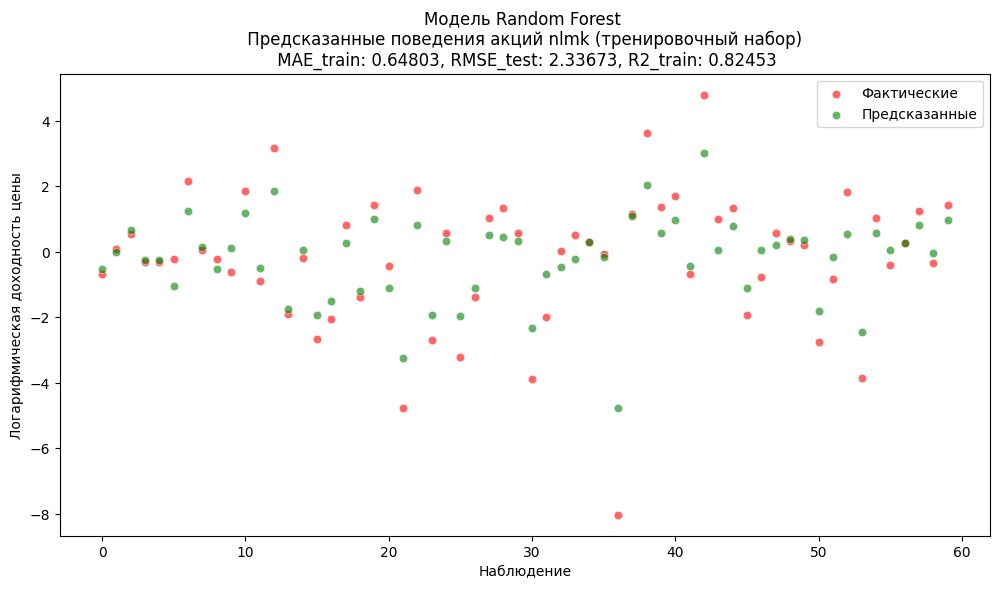

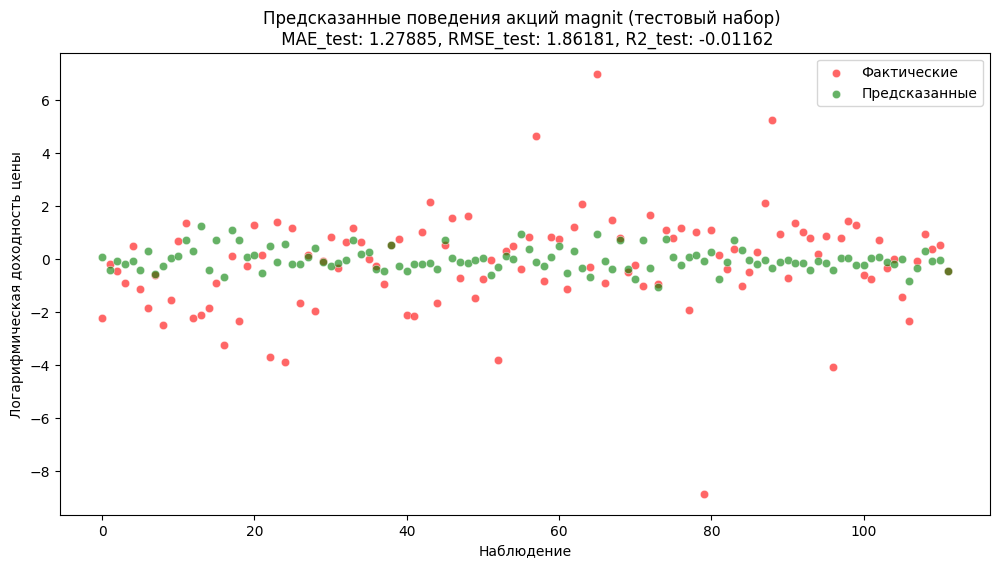

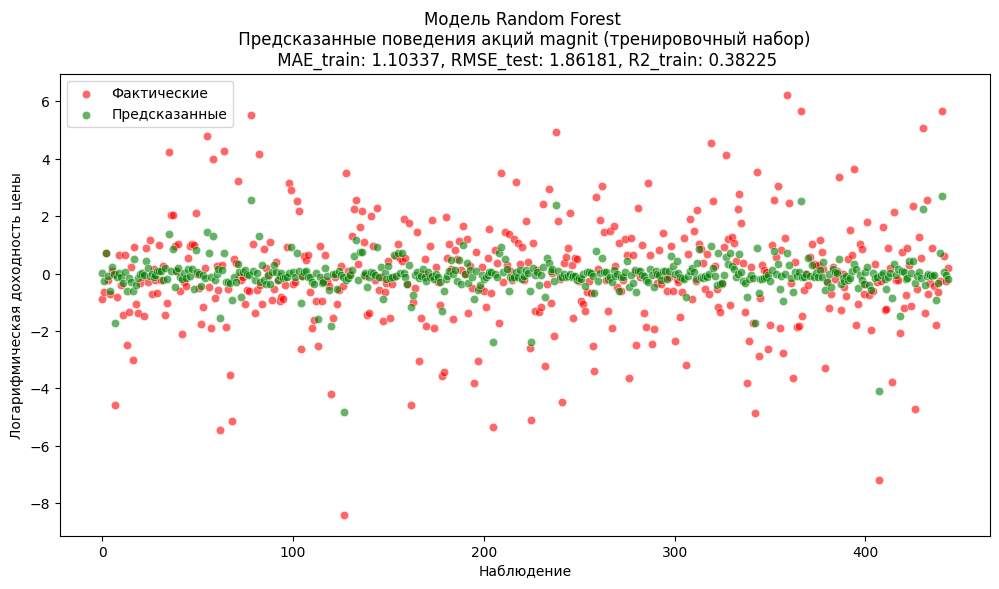

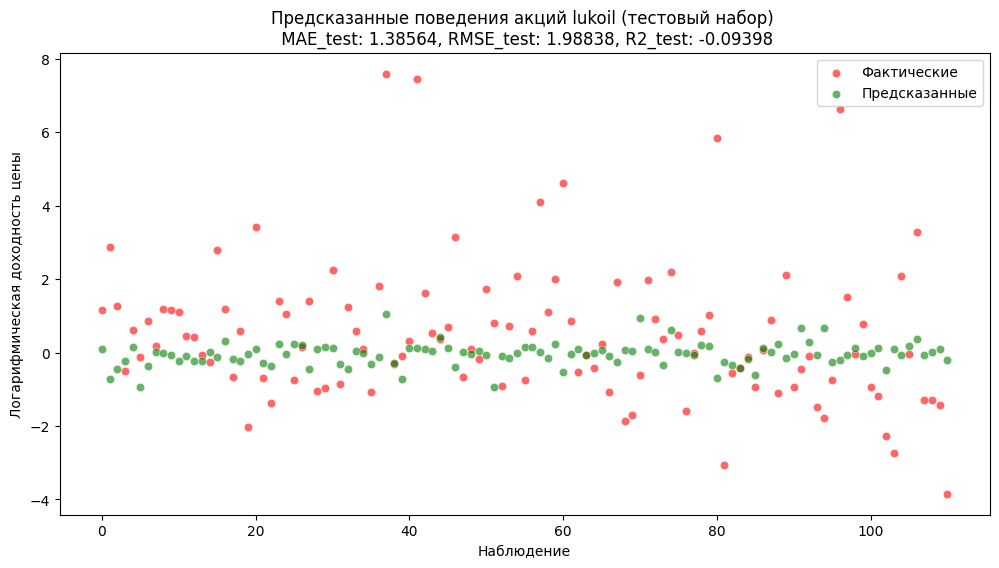

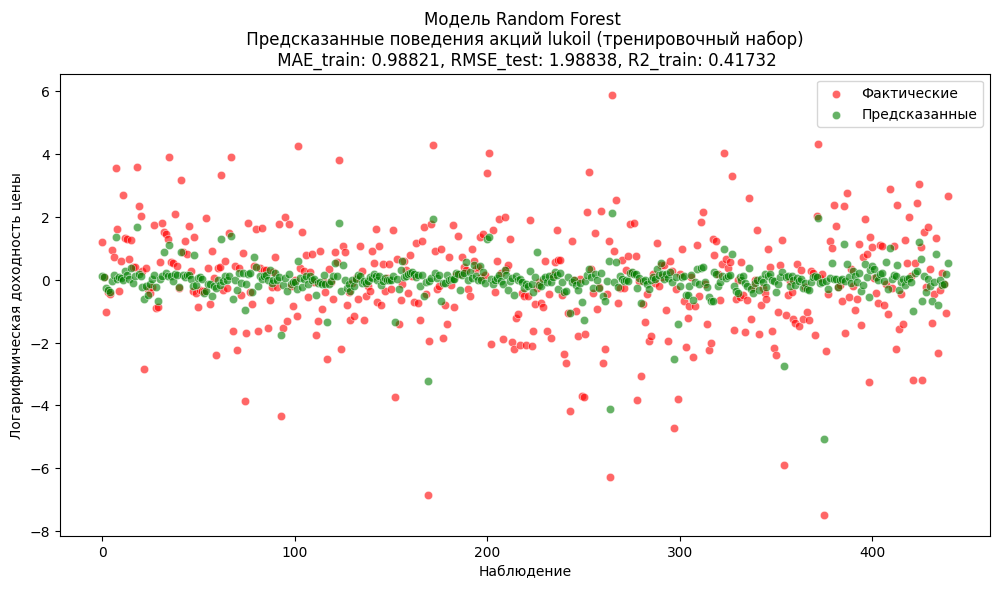

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
rf_results = []
for company in final_df['Company'].unique():
    company_df = final_df[final_df['Company'] == f'{company}'].copy()
    embeddings = np.array(company_df['embedding'].tolist())  # Преобразуем список эмбеддингов в массив numpy
    df_embeddings = pd.DataFrame(embeddings)
    X_company = df_embeddings
    y_company = company_df['Лаг 1 день %']
    X_train, X_test, y_train, y_test = train_test_split(X_company, y_company, test_size=0.2, random_state=42)
    from sklearn.ensemble import RandomForestRegressor
    forest_model = RandomForestRegressor(n_estimators = 150, min_samples_leaf = 1, min_samples_split = 2, max_depth = 5)

    forest_model.fit(X_train, y_train)
    y_pred_company_test = forest_model.predict(X_test)
    y_pred_company_train = forest_model.predict(X_train)
    observation_test = np.arange(len(X_test))
    observation_train = np.arange(len(X_train))
    MAE_test = mean_absolute_error(y_test, y_pred_company_test)
    MSE_test = mean_squared_error(y_test, y_pred_company_test)
    RMSE_test = np.sqrt(MSE_test)
    std_test = np.std(y_test)
    R2_test = r2_score(y_test, y_pred_company_test)
    MAE_train = mean_absolute_error(y_train, y_pred_company_train)
    MSE_train = mean_squared_error(y_train, y_pred_company_train)
    RMSE_train = np.sqrt(MSE_train)
    std_train = np.std(y_train)
    R2_train = r2_score(y_train, y_pred_company_train)
    rf_results.append({
    'company': company,
    'mse_test': MSE_test,
    'mse_train': MSE_train,
    'rmse_test': RMSE_test,
    'std_test': std_test,
    'rmse_train': RMSE_train,
    'r2_test': R2_test,
    'r2_train': R2_train,
    'std_train': std_train})


    plt.figure(figsize=(12, 6))
    sns.scatterplot(x = observation_test, y = y_test, label= f"Фактические", color="red", alpha = 0.6)
    sns.scatterplot(x= observation_test, y = y_pred_company_test, label= f"Предсказанные", color="green",  alpha = 0.6)
    plt.title(f"Предсказанные поведения акций {company} (тестовый набор) \n MAE_test: {np.round(MAE_test, 5)}, RMSE_test: {np.round(RMSE_test,5)}, R2_test: {np.round(R2_test,5)}" )
    plt.xlabel("Наблюдение")
    plt.ylabel("Логарифмическая доходность цены")
    plt.legend()

    plt.show()


    plt.figure(figsize=(12, 6))
    sns.scatterplot(x = observation_train, y = y_train, label= f"Фактические", color="red", alpha = 0.6)
    sns.scatterplot(x= observation_train, y = y_pred_company_train, label= f"Предсказанные", color="green",  alpha = 0.6)
    plt.title(f"Модель Random Forest \n Предсказанные поведения акций {company} (тренировочный набор) \n MAE_train: {np.round(MAE_train, 5)}, RMSE_test: {np.round(RMSE_test,5)}, R2_train: {np.round(R2_train,5)}" )
    plt.xlabel("Наблюдение")
    plt.ylabel("Логарифмическая доходность цены")
    plt.legend()

    plt.show()

**Глядя на графики становится понятно, что модель совсем не предсказывает изменение логарифмических доходностей на основе новостей**